The dataset that I use is the ORL Database of Faces, which is quite of age but we can download it from Kaggle:

[https://www.kaggle.com/kasikrit/att-database-of-faces/download](https://www.kaggle.com/kasikrit/att-database-of-faces/download)

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import cv2 
import zipfile 

%matplotlib inline 

In [8]:
faces = {}
with zipfile.ZipFile("../datasets/att-faces.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

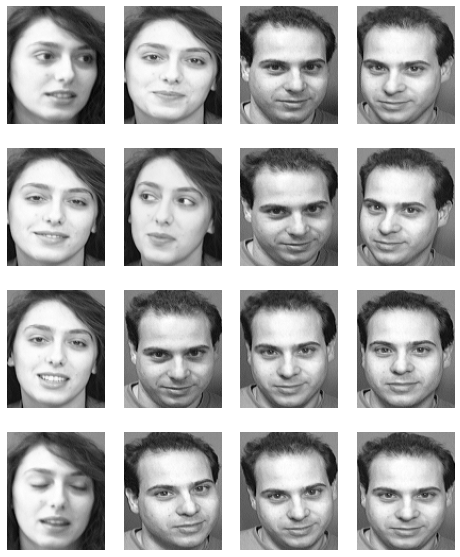

In [10]:
import matplotlib.pyplot as plt
 
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
    axes[i%4][i//4].axis('off')
plt.show()

In [11]:
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

Face image shape: (112, 92)


In [12]:
print(list(faces.keys())[:5])

['s1/1.pgm', 's1/10.pgm', 's1/2.pgm', 's1/3.pgm', 's1/4.pgm']


In [13]:
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of pictures:", len(faces))

Number of classes: 40
Number of pictures: 400


In [14]:

# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s40/"):
        continue # this is our test set
    if key == "s39/10.pgm":
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])
 
# Create facematrix as (n_samples,n_pixels) matrix
facematrix = np.array(facematrix)

In [15]:
from sklearn.decomposition import PCA
 
pca = PCA().fit(facematrix)

In [16]:
print(pca.explained_variance_ratio_)

[1.77824822e-01 1.29057925e-01 6.67093882e-02 5.63561346e-02
 5.13040312e-02 3.39156477e-02 2.47893586e-02 2.27967054e-02
 1.95632067e-02 1.82678428e-02 1.45655853e-02 1.38626271e-02
 1.13318896e-02 1.07267786e-02 9.68365599e-03 9.17860717e-03
 8.60995215e-03 8.21053028e-03 7.36580634e-03 7.01112888e-03
 6.69450840e-03 6.40327943e-03 5.98295099e-03 5.49298705e-03
 5.36083980e-03 4.99408106e-03 4.84854321e-03 4.77687371e-03
 4.50099203e-03 4.35061143e-03 4.27684434e-03 4.05463914e-03
 3.96785012e-03 3.83241704e-03 3.69966355e-03 3.56356652e-03
 3.41269732e-03 3.33215240e-03 3.17642634e-03 3.03400142e-03
 2.97464206e-03 2.91054493e-03 2.86082016e-03 2.78052126e-03
 2.69873388e-03 2.60122139e-03 2.56106677e-03 2.50435737e-03
 2.44154438e-03 2.35425118e-03 2.31772334e-03 2.20335201e-03
 2.18249599e-03 2.16369451e-03 2.11113501e-03 2.05410950e-03
 2.00521036e-03 1.97423272e-03 1.95619744e-03 1.92361114e-03
 1.88146543e-03 1.81655157e-03 1.74212750e-03 1.70581678e-03
 1.66405571e-03 1.635671

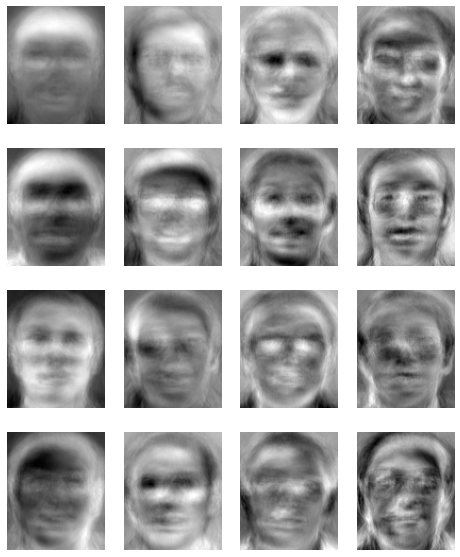

In [18]:
n_components = 50
eigenfaces = pca.components_[:n_components]
 
# Show the first 16 eigenfaces
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
    axes[i%4][i//4].axis('off')
plt.show()

In [19]:
# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
weights = eigenfaces @ (facematrix - pca.mean_).T

In [22]:
weights = []
for i in range(facematrix.shape[0]):
    weight = []
    for j in range(n_components):
        w = eigenfaces[j] @ (facematrix[i] - pca.mean_)
        weight.append(w)
    weights.append(weight)

Shape of the weight matrix: (50, 389)
Best match s39 with Euclidean distance 1559.997137


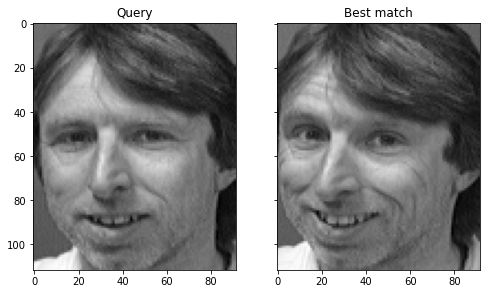

Best match s5 with Euclidean distance 2690.209330


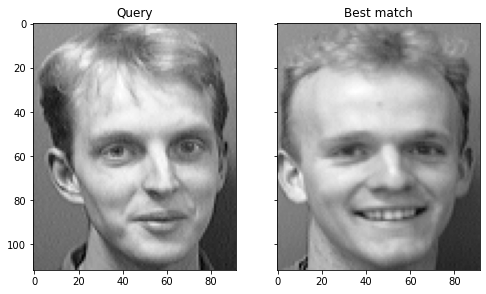

In [26]:
# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
weights = eigenfaces @ (facematrix - pca.mean_).T
print("Shape of the weight matrix:", weights.shape)
 
# Test on out-of-sample image of existing class
query = faces["s39/10.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()
 
# Test on out-of-sample image of new class
query = faces["s40/1.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()